# Chest x-ray diagnosis using deep learning models
# Data exploration and sampling to deal with label umbalance
## The model structure to study: DenseNet-121 (Densely Connected Convolutional Networks)
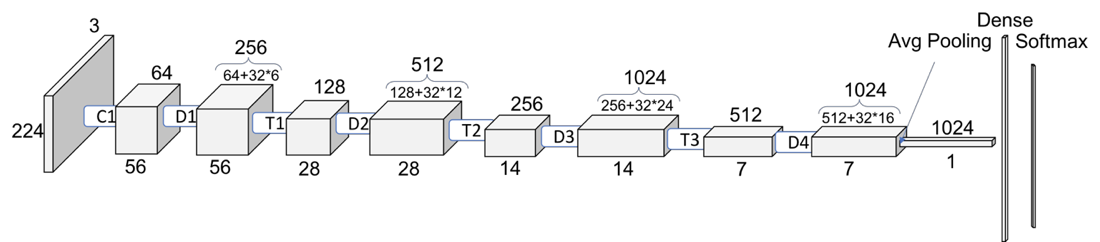

## Data Source: Stanford ChexPert Data - [CheXpert-v1.0-small]( https://stanfordmlgroup.github.io/competitions/chexpert/)

In [1]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#import pydotplus
#import pydot as pyd
#from keras.utils.vis_utils import model_to_dot
#keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


## data preprocessing
- Only frontal images 

- Only images considered as inputs to the model. "Sex", "Age", "Frontal/Lateral", and "AP/PA" features were removed from training data
- Combined the downloaded validation data with train data as the validation data size was very small (200 images)


In [2]:
dtrain=pd.read_csv("CheXpert-v1.0-small/train.csv")
dtrain = dtrain.fillna(0)
# import valid data info from valid.csv
dnew=pd.read_csv("CheXpert-v1.0-small/valid.csv")
dnew = dnew.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
dtrain = dtrain.append(dnew)

#pre-process data: remove Lateral images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]
#pre-process data: drop selected features - only images as inputs
dtrain = dtrain.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)
#print(dtrain.shape)
#dtrain.describe().transpose()

 - Since this model is used as a first pass for chest x-ray diagnosis, false negative has higher cost and all uncertainties were consdiered as positive (replaced -1 by 1)
 - Data statistics show Lung Opacity, Edema, Atelectasis, Pleural Effusion and Support Devices have more balanced positive versus negative cases. The resut of observations have less than 25% of positive observations

In [3]:
# dealing with uncertanty (-1) values
dtrain = dtrain.replace(-1,1)
dtrain.describe().transpose()
print(list(dtrain.columns))
#print(len(list(dtrain.columns)))
print(list(dtrain.columns[1:15]))

['Path', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


Data Exploration

In [4]:
features_size=[]
features_data =[]
features_name=[]
#print(list(dtrain.columns[1:15]))
for feature in list(dtrain.columns[1:15]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)
    
print(dtrain.shape)
print(list(dtrain.columns[1:15]))
#print(features_name)
#print(list(dtrain.columns))
print(features_size)
print(np.array(features_size)/dtrain.shape[0]*100)
#print(len(list(dtrain.columns[1:15])))
#print(len(features_data[0]))
#aa=features_data[0]
#print(features_data[0][0:2])


(191229, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
[17000, 19578, 30158, 98759, 8149, 61535, 37396, 20664, 59658, 20408, 86541, 4318, 7935, 108184]
[ 8.88986503 10.23798692 15.77062056 51.64436356  4.26138295 32.17869675
 19.55561134 10.80589241 31.19715106 10.6720215  45.25516527  2.25802572
  4.14947524 56.57300932]


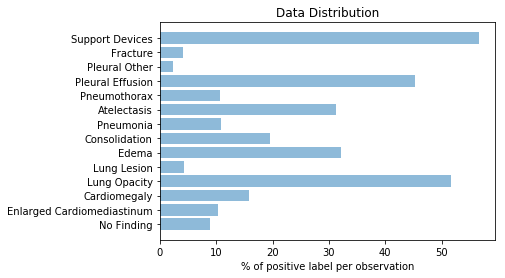

<Figure size 432x288 with 0 Axes>

In [5]:
%matplotlib inline
objects = list(dtrain.columns[1:15])
y_pos = np.arange(len(objects))
performance = np.array(features_size)/dtrain.shape[0]*100

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute.png', bbox_inches='tight')


['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


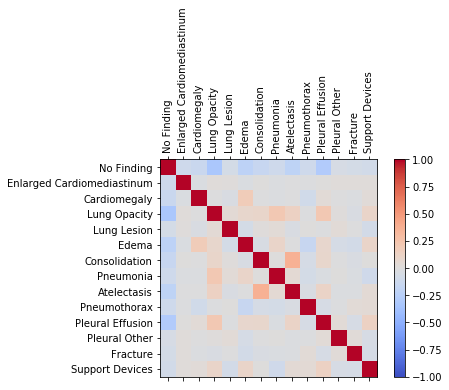

<Figure size 432x288 with 0 Axes>

In [6]:
#dtrain.corr(method='pearson')
#print(list(dtrain.columns[1:15]))
data = dtrain[list(dtrain.columns[1:15])]
print(list(dtrain.columns[1:15]))
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()
plt.savefig('Correlation.png', bbox_inches='tight')


Data sampling to balance labels

In [7]:
dtrain_upsample=[]
dtrain_upsample_list=[]
# dtrain_upsample_list = [features_data[0],
#                        features_data[1],
#                        features_data[2],
#                        features_data[3],
#                        features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],
#                        features_data[5],
#                        features_data[6],
#                        features_data[7],
#                        features_data[8],
#                        features_data[9],
#                        features_data[10],
#                        features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],
#                        features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],
#                        features_data[13]]
dtrain_upsample_list = [features_data[0],features_data[0],features_data[0],features_data[0],
                       features_data[1],
                       features_data[2],
                       features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],
                       features_data[5],
                       features_data[6],
                       features_data[7],
                       features_data[8],
                       features_data[9],
                       features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],
                       features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12]]

dtrain_upsample = pd.concat(dtrain_upsample_list) 
print(dtrain_upsample.shape)
print(list(dtrain_upsample.columns[1:15]))

(497398, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


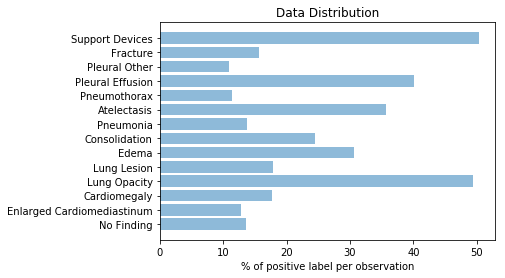

<Figure size 432x288 with 0 Axes>

In [8]:
features_sizeR=[]
features_dataR =[]
features_nameR=[]
#print(list(dtrain.columns[1:15]))
for featureR in list(dtrain_upsample.columns[1:15]):
    data_featureR = dtrain_upsample.loc[dtrain_upsample[featureR] == 1]
    features_sizeR.append(data_featureR.shape[0])
    features_dataR.append(data_featureR)
    features_nameR.append(featureR)

objectsR = list(dtrain_upsample.columns[1:15])
y_posR = np.arange(len(objectsR))
performanceR = np.array(features_sizeR)/dtrain_upsample.shape[0]*100

plt.barh(y_posR, performanceR, align='center', alpha=0.5)
plt.yticks(y_posR, objectsR)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute_sampling.png', bbox_inches='tight')

Split data to train/dev/test - 10% for development and test

In [9]:
### split data into train/valid/test
#shuffle data 
dtrain_upsample = dtrain_upsample.sample(frac=1)
#split data
dvalid_size = round(0.1*dtrain_upsample.shape[0])
dtest_size = dvalid_size
dtr = dtrain_upsample[0:dtrain_upsample.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain_upsample[dtrain_upsample.shape[0]-dvalid_size-dtest_size:dtrain_upsample.shape[0]-dvalid_size+1]
dte = dtrain_upsample[dtrain_upsample.shape[0]-dvalid_size:dtrain_upsample.shape[0]+1]


In [10]:
print(dtrain_upsample.shape)
print(dtr.shape)
dtr.describe().transpose()

(497398, 15)
(397919, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,397919.0,0.136746,0.343580,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,397919.0,0.128720,0.334890,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,397919.0,0.177116,0.381768,0.0,0.0,0.0,0.0,1.0
Lung Opacity,397919.0,0.493432,0.499957,0.0,0.0,0.0,1.0,1.0
Lung Lesion,397919.0,0.178494,0.382928,0.0,0.0,0.0,0.0,1.0
Edema,397919.0,0.307301,0.461376,0.0,0.0,0.0,1.0,1.0
Consolidation,397919.0,0.245125,0.430162,0.0,0.0,0.0,0.0,1.0
Pneumonia,397919.0,0.137862,0.344756,0.0,0.0,0.0,0.0,1.0
Atelectasis,397919.0,0.356037,0.478827,0.0,0.0,0.0,1.0,1.0
Pneumothorax,397919.0,0.113845,0.317623,0.0,0.0,0.0,0.0,1.0


In [11]:
print(dv.shape)
dv.describe().transpose()

(49741, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,49741.0,0.140146,0.347142,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,49741.0,0.125490,0.331277,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,49741.0,0.176715,0.381431,0.0,0.0,0.0,0.0,1.0
Lung Opacity,49741.0,0.489496,0.499895,0.0,0.0,0.0,1.0,1.0
Lung Lesion,49741.0,0.178525,0.382958,0.0,0.0,0.0,0.0,1.0
Edema,49741.0,0.306065,0.460862,0.0,0.0,0.0,1.0,1.0
Consolidation,49741.0,0.246899,0.431212,0.0,0.0,0.0,0.0,1.0
Pneumonia,49741.0,0.136185,0.342989,0.0,0.0,0.0,0.0,1.0
Atelectasis,49741.0,0.355160,0.478567,0.0,0.0,0.0,1.0,1.0
Pneumothorax,49741.0,0.114775,0.318753,0.0,0.0,0.0,0.0,1.0


In [12]:
print(dte.shape)
dte.describe().transpose()

(49740, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,49740.0,0.132992,0.339569,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,49740.0,0.130860,0.337251,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,49740.0,0.176116,0.380922,0.0,0.0,0.0,0.0,1.0
Lung Opacity,49740.0,0.498311,0.500002,0.0,0.0,0.0,1.0,1.0
Lung Lesion,49740.0,0.180941,0.384973,0.0,0.0,0.0,0.0,1.0
Edema,49740.0,0.306072,0.460864,0.0,0.0,0.0,1.0,1.0
Consolidation,49740.0,0.243567,0.429238,0.0,0.0,0.0,0.0,1.0
Pneumonia,49740.0,0.139405,0.346372,0.0,0.0,0.0,0.0,1.0
Atelectasis,49740.0,0.359590,0.479885,0.0,0.0,0.0,1.0,1.0
Pneumothorax,49740.0,0.117672,0.322222,0.0,0.0,0.0,0.0,1.0


 - Image target size as input to the model are **224*224**
 - Batch size is set to **32** for training and validation set. 
 - For test set, shuffle is set to false to be able to compute F1 score later through prediction of test data. 

In [13]:
### data generation for Keras 
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

target_size = (224,224)
#target_size = (299,299)
#target_size = (75,75)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , x_col="Path", y_col=list(dtr.columns[1:15]), class_mode="other", drop_duplicates = False, target_size=target_size, batch_size=32)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None, x_col="Path", y_col=list(dv.columns[1:15]), class_mode="other", drop_duplicates = False, target_size=target_size, batch_size=32)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None, x_col="Path", y_col=list(dte.columns[1:15]), class_mode="other", drop_duplicates = False, target_size=target_size, shuffle = False, batch_size=1)


Found 397919 images.
Found 49741 images.
Found 49740 images.


- DenseNet-121 is selected for CNN structure. A global average 2D pooling layer, a fully connected dense layer with 1024 nodes and Relu activation, and finally a fully connected dense layer with 14 nodes (representing 14 classes for chest x-ray observations) and sigmoid activation are added to modify DenseNet-121 architecture for our application. The weights are initialized with a network weights tuned for imagenet data. <font color=blue>All weights are tuned.</font>
- loss function is defined as binary cross entropy loss. 
- Adam optimizer selected with lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False


In [14]:
### model architecture design/selection
# create the base pre-trained model
#base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = DenseNet121(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer 
predictions = Dense(14, activation='sigmoid')(x)


# this is the model we will train
model_F = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

#model training

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_F.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])
#model_F.compile(optimizer= adam, loss='binary_crossentropy', loss_weights=[1,1,1,1,1,1,1,1,1,1,1,1,1,1], metrics=['accuracy'])
#model_F.compile(optimizer= adam, loss=loss, metrics=['accuracy'])

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model_F.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________________

Fit the model on aws with epochs = 3. Model is saved after fiting is done.

In [ ]:
### fit model 
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model_H = model_F.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs)
# save model
model_F.save("model_DenseNet121_Full_Sample.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
 6032/12434 [=============>................] - ETA: 1:34:41 - loss: 0.4030 - acc: 0.8182

load the trained model here.

In [13]:
model_F = load_model('model_DenseNet121_Full_Sample.h5')
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Calculate precision, recall, and f1-score on train data. **The threshold for positive is set to 0.5**

In [15]:
### prediction and performance assessment
test_generator.reset()
pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

                            precision    recall  f1-score   support

                No Finding       0.77      0.06      0.11      1683
Enlarged Cardiomediastinum       0.75      0.00      0.00      1928
              Cardiomegaly       0.66      0.49      0.56      3089
              Lung Opacity       0.63      0.87      0.73      9920
               Lung Lesion       0.67      0.04      0.08       799
                     Edema       0.64      0.74      0.69      6200
             Consolidation       0.52      0.03      0.06      3727
                 Pneumonia       0.56      0.08      0.14      2112
               Atelectasis       0.58      0.32      0.41      5879
              Pneumothorax       0.77      0.24      0.36      2053
          Pleural Effusion       0.69      0.91      0.79      8679
             Pleural Other       0.50      0.01      0.01       433
                  Fracture       0.57      0.02      0.03       755
           Support Devices       0.89      0.73

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Calculate accuracy on test data

In [16]:
score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.33800358284421234
Test accuracy: 0.852746499271714
